In [ ]:
%load_ext autoreload
%autoreload 2
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"  # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = '3'
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "true"  # add this

In [ ]:
# os.environ["XLA_PYTHON_CLIENT_ALLOCATOR"] = "platform"
from kheiron.pipeline.registry import Registry
from hydra_zen import instantiate
import haiku as hk
import jax
import functools
from tqdm import tqdm
import jax.numpy as jnp

import sys 
sys.path.append('../../')

import py3Dmol

def traj_to_pdb(traj, downsample=1, tail=20):
    models = ""
    traj = traj[::downsample] + [traj[-1]] * tail
    for i, p in enumerate(tqdm(traj)):
        models += f"MODEL {i + 1}\n"
        models += p.to_pdb_str()
        models += "\nENDMDL\n"
    return models

def plot_py3dmol_traj(traj, window_size=(400, 400), duration=10000):
    # interval = duration / len(traj)
    v = py3Dmol.view(*window_size)
    models = traj_to_pdb(traj)
    v.addModelsAsFrames(models, 'pdb')
    v.setStyle({})
    v.addStyle({'atom': 'CA'}, {'sphere': {'radius': 0.5, 'color': 'darkgray'}})
    v.addStyle({'chain': 'A'}, {'stick': {}})
    v.setBackgroundColor("rgb(0,0,0)", 0)
    v.animate({'loop': 'forward'})
    return v


In [ ]:
registry_path = '/mas/projects/molecularmachines/experiments/generative/allanc3'
registry = Registry('ophiuchus', registry_path)
model_name = 'wise-darkness-1244'
plat = registry.get_platform(model_name, read_only=True)

In [ ]:
dataset = instantiate(plat.cfg['trainer']['dataset']) 

In [ ]:
x0 = dataset[0]
x0.to_dict()

In [ ]:
params = plat.get_params(-1)
premodel = plat.instantiate_model()
transform = hk.transform(lambda *a, **ka: premodel().sample(*a, **ka))

from model.base.utils import inner_stack, inner_split

def batch_dict(list_):
    keys = list_[0].keys()
    return {k: jnp.stack([d[k] for d in list_]) for k in keys if list_[0][k] is not None}


def unbatch_dict(d):
    keys = d.keys()
    return [{k: d[k][i] for k in keys} for i in range(d[list(keys)[0]].shape[0])]


@functools.partial(jax.jit, static_argnums=(2,))
def _simulate(key, prot, interp_steps=100, eps=jnp.array([1.0,1.0])):
    keys = jax.random.split(key, prot['atom_coord'].shape[0]) 
    return jax.vmap(lambda k, p: transform.apply(params, k, p, num_steps=1, interp_steps=interp_steps, eps=eps))(keys, prot)

def rollout(prot, num_steps, interp_steps, eps):
    traj = []
    prot = batch_dict(prot)
    for _ in tqdm(range(num_steps)):
        prot, _ = _simulate(next(rng_seq), prot, interp_steps=interp_steps, eps=eps)
        traj.append(unbatch_dict(prot))
    prot = unbatch_dict(prot)
    return prot, traj


rng_seq = hk.PRNGSequence(42)
x0 = dataset.splits['train'][0]
# unbatch_dict(batch_dict([x0.to_dict()]))[0]
# _ = rollout([x0.to_dict(), x0.to_dict()], num_steps=1, interp_steps=300, eps=jnp.array([1.0,1.0]))


In [ ]:
from torch.utils.data import DataLoader

BATCH_SIZE = 30
dataloader = DataLoader(
    dataset,
    batch_size=BATCH_SIZE,
    num_workers=10,
    collate_fn=lambda x: [x.to_dict() for x in x]
)
x = next(iter(dataloader))

In [59]:
samples = []
for _ in range(10):
    x = next(iter(dataloader))
    _, ensemble = rollout(x, num_steps=100, interp_steps=400, eps=jnp.array([1.0, 1.0]))
    traj = [s for traj in ensemble for s in traj]
    samples.extend(traj)

100%|██████████| 100/100 [01:23<00:00,  1.20it/s]


In [ ]:
plot_py3dmol_traj([ProteinDatum(idcode=None,sequence=None,resolution=None, **p[0]) for p in ensemble], window_size=(800, 800), duration=10000)

In [ ]:
import pickle
with open('cache_traj.pkl', 'wb') as f:
    pickle.dump(traj, f)

In [ ]:
# plot_py3dmol_traj([ProteinDatum(idcode=None, resolution=None, sequence=None, **d) for d in [E[0] for E in traj]], window_size=(400, 400))


In [ ]:
# x1, traj = rollout(x0, num_steps=100, interp_steps=500, eps=jnp.array([1.0, 3.0]))

In [ ]:
plot_py3dmol_traj(traj, window_size=(400, 400))


In [ ]:
import mdtraj
from pathlib import Path
# get the xtc path and get its directory
reference = Path(dataset.files[0])
reference_dir = reference.parent
reference = mdtraj.load(reference_dir / 'filtered.pdb')
reference_top = reference.top.subset(reference.top.select('protein'))


reference_traj = mdtraj.Trajectory(
    xyz=dataset.coords, topology=reference_top
)

# # ref_train, ref_val, ref_test = np.split(reference_ca_coords, [int(0.7 * len(reference_ca_coords)), int(0.9 * len(reference_ca_coords))])


In [67]:
import mdtraj as md
from tempfile import gettempdir
from moleculib.protein.datum import ProteinDatum

import os
import numpy as np

def protein_datum_to_md_traj(traj, downsample=1):
    ref = traj[0]
    with open(f'{gettempdir()}/tmp.pdb', 'w') as f:
        f.write(ProteinDatum(idcode=None, resolution=None, sequence=None, **ref).to_pdb_str())
    template = md.load(f'{gettempdir()}/tmp.pdb')
    os.remove(f'{gettempdir()}/tmp.pdb')
    all_atom_coord = [step['atom_coord'][step['atom_mask']] for step in traj]
    md_traj = md.Trajectory(
        xyz=np.stack(all_atom_coord),
        topology=template.topology,
    )
    return md_traj

sampled_traj = protein_datum_to_md_traj(samples)


### Ramachandran

In [ ]:
import mdtraj as md
import numpy as np
import matplotlib.pyplot as plt


def compute_phi_and_psi_angles(traj: md.Trajectory) -> float:
    # filter_backbone 
    # traj = traj.atom_slice(traj.top.select('backbone'))
    _, phi_angles = md.compute_phi(traj)
    _, psi_angles = md.compute_psi(traj)

    phi_angles = np.rad2deg(phi_angles).flatten() # dropping the first one?
    psi_angles = np.rad2deg(psi_angles).flatten()
    return phi_angles, psi_angles

def compute_KL_divergence(hist1: np.ndarray, hist2: np.ndarray) -> float:
    """Compute the Kullback-Leibler divergence between two histograms."""
    hist2 = np.where(hist2 == 0, 1, hist2)
    div = hist1 * np.nan_to_num(np.log(hist1 / hist2))
    div = np.where(hist1 == 0, 0, div)
    return np.sum(div)

hists = []

import matplotlib as mpl

for label, traj_ in zip(('Reference', 'Model'), (reference_traj, sampled_traj)):
# for label, traj_ in zip(('Model',), (reference_traj,)):    
    phi_angles, psi_angles = compute_phi_and_psi_angles(traj_)
    histo = np.histogram2d(
        -psi_angles, phi_angles, bins=np.linspace(-180, 180, 60), density=True
    )[0]

    plt.imshow(histo)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.xlabel('$\phi$', fontsize=20)
    plt.ylabel('$\psi$', fontsize=20)

    plt.title(label)
    plt.show()
    hists.append(histo)


# js = compute_JS_divergence(*hists)
# print(f"JS divergence: {js:.5f}")

# kl = compute_KL_divergence(*hists)
# print(f"KL divergence: {kl:.5f}")



### PWD

In [ ]:
from einops import rearrange

def compute_pairwise_distances(traj):
    ca_coord = traj.xyz[:, traj.top.select('name CA')]
    pairwise_distances = np.linalg.norm(rearrange(ca_coord, 'b n d -> b n () d') - rearrange(ca_coord, 'b m d -> b 1 m d'), axis=-1)    
    return pairwise_distances

def compute_distogram(distance_maps, k=3, nbins=60):
    trig = np.triu_indices(distance_maps.shape[-1], k=3)
    distances = distance_maps[..., trig[0], trig[1]].T
    binned = np.apply_along_axis(lambda a: np.histogram(a, bins=nbins, density=True)[0], 1, distances)
    return binned


pwd_hists = []

for label, traj_ in zip(('Reference', 'Model'), (reference_traj, sampled_traj)):
    distance_map = compute_pairwise_distances(traj_)
    if label == 'Reference': distogram = compute_distogram(distance_map[::1000])
    else: distogram = compute_distogram(distance_map)
    # show as upper triangular matrix:
    seq_len = distance_map.shape[1]
    distogram_full = np.zeros((seq_len, seq_len))
    distogram_full[np.triu_indices(seq_len, k=3)] = distogram.mean(-1)
    distogram_full += distogram_full.T
    plt.imshow(distogram_full)
    plt.title(label)
    plt.show()
    
    pwd_hists.append(distogram_full)

from scipy.spatial.distance import jensenshannon

ref_pwd, model_pwd = pwd_hists
js = jensenshannon(ref_pwd[np.triu_indices(ref_pwd.shape[0], k=3)], model_pwd[np.triu_indices(model_pwd.shape[0], k=3)])
print(js)

### TICA Coordinates

In [ ]:
from einops import rearrange

from pyemma.coordinates.transform import TICA
import numpy as np


def compute_tica_features(traj):
    coord = traj.xyz[:, traj.top.select('name CA')]
    pairwise_distances = np.linalg.norm(rearrange(coord, 'b n d -> b n () d') - rearrange(coord, 'b m d -> b 1 m d'), axis=-1)
    return pairwise_distances.reshape(-1, pairwise_distances.shape[-1] ** 2)


# tica = TICA(lag=100, dim=2).fit(compute_tica_features(reference_traj))
reference_tics = tica.get_output()[0]
train_tics, val_tics, test_tics = np.split(reference_tics, [int(0.7 * len(reference_tics)), int(0.9 * len(reference_tics))])

In [ ]:
with open('cache_tica.pkl', 'wb') as f:
    pickle.dump(tica, f)

In [68]:
model_tics = tica.transform(compute_tica_features(sampled_traj))


/tmp/ipykernel_27429/1490165665.py:26: RuntimeWarning:

divide by zero encountered in log



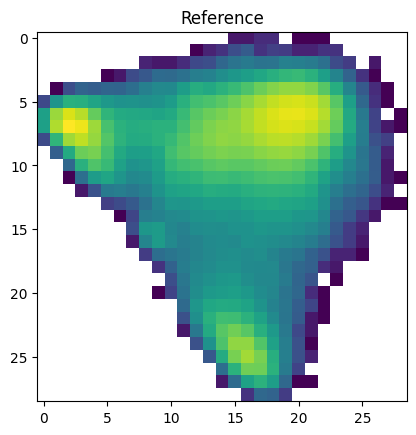

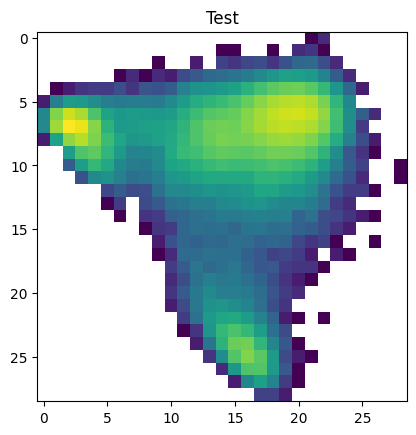

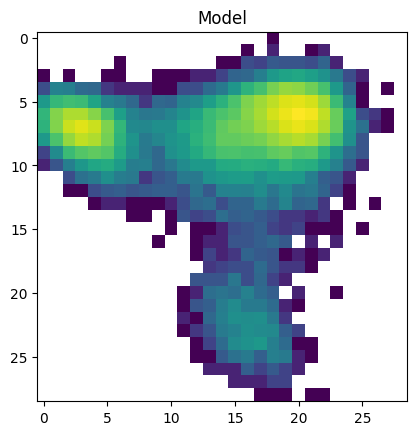

JS REFERENCE [0.01077405 0.01991175 0.0171754  0.00898039 0.01617277 0.0326087
 0.06096455 0.09305774 0.20784907 0.21941622 0.10077622 0.05761983
 0.052482   0.04166323 0.04062402 0.03783957 0.02520933 0.03239652
 0.02964008 0.0191905  0.0224741  0.02417145 0.0279291  0.0345567
 0.10139071 0.2714582  0.55769925        nan 0.67413231]
JS MODEL [0.32340197 0.29170691 0.23362396 0.13443771 0.11313027 0.10319965
 0.06829405 0.14753929 0.24908073 0.24808686 0.18327316 0.15962265
 0.11110376 0.09391961 0.13864296 0.24430046 0.26856587 0.1964255
 0.10423209 0.08028602 0.06355321 0.05127987 0.0716277  0.08666854
 0.12740854 0.33029123 0.67503283 0.72016176        nan]


/u/allanc/mambaforge/envs/ophiuchus/lib/python3.10/site-packages/scipy/spatial/distance.py:1250: RuntimeWarning:

invalid value encountered in true_divide



In [ ]:
import matplotlib.pyplot as plt
import matplotlib as mpl


# fig, ax = plt.subplots(1, 3, figsize=(10, 5))
# plt.figure(figsize=(5, 5))
# ax[0].hist2d(*train_tics.T, bins=60, cmap='viridis', density=True, norm=mpl.colors.LogNorm())
# # get range of ax[0]
# ax0_range = ax[0].get_xlim(), ax[0].get_ylim()

# ax[1].hist2d(*model_tics.T, bins=60, cmap='viridis', density=True, norm=mpl.colors.LogNorm())
# ax[1].set_xlim(*ax0_range[0])
# ax[1].set_ylim(*ax0_range[1])
# ax[2].hist2d(*test_tics.T, bins=60, cmap='viridis', density=True, norm=mpl.colors.LogNorm())
# # set range of ax[1]
# plt.show()
x_train, y_train = train_tics.T
tic_hists = []
NBINS = 30
for label, tics in zip(('Reference', 'Test', 'Model'), (train_tics, test_tics, model_tics)):
    x, y = tics.T
    histo = np.histogram2d(
        y, x, density=True,
        bins = [np.linspace(y_train.min(), y_train.max(), NBINS), np.linspace(x_train.min(), x_train.max(), NBINS)]
    )[0]
    plt.imshow(np.log(histo))
    plt.title(label)
    plt.show()
    tic_hists.append(histo)

tic_hist_ref, tic_hist_test, tic_hist_model = tic_hists

js_model = jensenshannon(tic_hist_ref.flatten(), tic_hist_model.flatten())
js_ref = jensenshannon(tic_hist_ref.flatten(), tic_hist_test.flatten())

print(f'JS REFERENCE {js_ref}')
print(f'JS MODEL {js_model}')



In [75]:
tic_hist_ref.shape

(29, 29)